<a href="https://www.kaggle.com/code/oscarm524/ps-s3-ep13-eda-modeling-submission?scriptVersionId=127457789" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

<a id="table"></a>
<h1 style="background-color:lightgray;font-family:newtimeroman;font-size:350%;text-align:center;border-radius: 15px 50px;">Table of Contents</h1>

[1. Notebook Versions](#1)

[2. Loading Libraries](#2)

[3. Reading Data Files](#3)

[4. Data Description](#4)

[5. Data Exploration](#5)

[6. MAP@k Metric](#6)

[7. Baseline Modeling 1.0](#7)

[8. Baseline Modeling 2.0](#8)

[9. Baseline Modeling 3.0](#9)

[10. Baseline Modeling 4.0](#10)

[11. Baseline Modeling 5.0](#11)

[12. Baseline Modeling 6.0](#12)

[13. Model Comparison](#13)

<a id="1"></a>
# <h1 style="background-color:lightgray;font-family:newtimeroman;font-size:350%;text-align:center;border-radius: 15px 50px;">Notebook Versions</h1>

1. Version 1 (04/18/2023)
    * EDA 
    * Baseline modeling 1.0  
    
2. Version 2 (04/18/2023)
    * Baseline modeling 1.0 updated
    
3. Version 3 (04/19/2023)
    * Baseline modeling 1.0 updated 
    * Baseline modeling 2.0 added
    * Model Comparison added

4. Version 4 (04/19/2023)
    * Baseline modeling 3.0 added
    * Model Comparisson updated
    
5. Version 5 (04/21/2023)
    * Baseline modeling 4.0 added
    
6. Version 6 (04/21/2023)
    * Baseline modeling 4.0 updated
    
7. Version 7 (04/24/2023)
    * Baseline modeling 5.0 updated
    
8. Version 8 (04/27/2023)
    * Baseline modeling 6.0 added
    

<a id="2"></a>
# <h1 style="background-color:lightgray;font-family:newtimeroman;font-size:350%;text-align:center;border-radius: 15px 50px;">Loading Libraries</h1>    

In [1]:
import pandas as pd; pd.set_option('display.max_columns', 100)
import numpy as np

from tqdm.notebook import tqdm

from functools import partial
import scipy as sp

import matplotlib.pyplot as plt; plt.style.use('ggplot')
import seaborn as sns
import plotly.express as px

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score, roc_curve, RocCurveDisplay, cohen_kappa_score, log_loss
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import RFE, RFECV
from sklearn.isotonic import IsotonicRegression
from sklearn.calibration import CalibrationDisplay
from sklearn.inspection import PartialDependenceDisplay
from sklearn.linear_model import LogisticRegression
from collections import Counter
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

<a id="3"></a>
# <h1 style="background-color:lightgray;font-family:newtimeroman;font-size:350%;text-align:center;border-radius: 15px 50px;">Reading Data Files</h1> 

In [2]:
train = pd.read_csv('../input/playground-series-s3e13/train.csv')
test = pd.read_csv('../input/playground-series-s3e13/test.csv')
submission = pd.read_csv('../input/playground-series-s3e13/sample_submission.csv')

train.drop(columns = 'id', axis = 1, inplace = True)
test.drop(columns = 'id', axis = 1, inplace = True)

train[train.columns.tolist()[0:64]] = train[train.columns.tolist()[0:64]].astype('int32')
test[test.columns.tolist()[0:64]] = test[test.columns.tolist()[0:64]].astype('int32')

print('The dimession of the train dataset is:', train.shape)
print('The dimession of the test dataset is:', test.shape)

The dimession of the train dataset is: (707, 65)
The dimession of the test dataset is: (303, 64)


In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 707 entries, 0 to 706
Data columns (total 65 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   sudden_fever           707 non-null    int32 
 1   headache               707 non-null    int32 
 2   mouth_bleed            707 non-null    int32 
 3   nose_bleed             707 non-null    int32 
 4   muscle_pain            707 non-null    int32 
 5   joint_pain             707 non-null    int32 
 6   vomiting               707 non-null    int32 
 7   rash                   707 non-null    int32 
 8   diarrhea               707 non-null    int32 
 9   hypotension            707 non-null    int32 
 10  pleural_effusion       707 non-null    int32 
 11  ascites                707 non-null    int32 
 12  gastro_bleeding        707 non-null    int32 
 13  swelling               707 non-null    int32 
 14  nausea                 707 non-null    int32 
 15  chills                 

In [4]:
train.head()

,sudden_fever,headache,mouth_bleed,nose_bleed,muscle_pain,joint_pain,vomiting,rash,diarrhea,hypotension,pleural_effusion,ascites,gastro_bleeding,swelling,nausea,chills,myalgia,digestion_trouble,fatigue,skin_lesions,stomach_pain,orbital_pain,neck_pain,weakness,back_pain,weight_loss,gum_bleed,jaundice,coma,diziness,inflammation,red_eyes,loss_of_appetite,urination_loss,slow_heart_rate,abdominal_pain,light_sensitivity,yellow_skin,yellow_eyes,facial_distortion,microcephaly,rigor,bitter_tongue,convulsion,anemia,cocacola_urine,hypoglycemia,prostraction,hyperpyrexia,stiff_neck,irritability,confusion,tremor,paralysis,lymph_swells,breathing_restriction,toe_inflammation,finger_inflammation,lips_irritation,itchiness,ulcers,toenail_loss,speech_problem,bullseye_rash,prognosis
0,1,1,0,1,1,1,1,0,1,1,1,1,0,0,1,1,0,0,1,0,1,0,1,1,1,1,1,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,Lyme_disease
1,0,0,0,0,0,0,1,0,1,0,1,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Tungiasis
2,0,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,0,0,1,1,1,1,0,1,0,1,1,1,0,1,1,1,1,0,1,0,0,0,1,1,1,1,1,1,1,1,1,1,0,1,1,1,Lyme_disease
3,0,0,1,1,1,1,0,1,0,1,1,0,0,1,1,1,0,1,1,1,1,1,0,1,0,0,1,1,1,1,1,1,1,0,0,0,1,1,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Zika
4,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,1,0,0,Rift_Valley_fever


In [5]:
train.describe()

,sudden_fever,headache,mouth_bleed,nose_bleed,muscle_pain,joint_pain,vomiting,rash,diarrhea,hypotension,pleural_effusion,ascites,gastro_bleeding,swelling,nausea,chills,myalgia,digestion_trouble,fatigue,skin_lesions,stomach_pain,orbital_pain,neck_pain,weakness,back_pain,weight_loss,gum_bleed,jaundice,coma,diziness,inflammation,red_eyes,loss_of_appetite,urination_loss,slow_heart_rate,abdominal_pain,light_sensitivity,yellow_skin,yellow_eyes,facial_distortion,microcephaly,rigor,bitter_tongue,convulsion,anemia,cocacola_urine,hypoglycemia,prostraction,hyperpyrexia,stiff_neck,irritability,confusion,tremor,paralysis,lymph_swells,breathing_restriction,toe_inflammation,finger_inflammation,lips_irritation,itchiness,ulcers,toenail_loss,speech_problem,bullseye_rash
count,707.000000,707.000000,707.000000,707.000000,707.000000,707.000000,707.000000,707.000000,707.000000,707.000000,707.000000,707.000000,707.000000,707.000000,707.000000,707.000000,707.000000,707.000000,707.000000,707.000000,707.000000,707.000000,707.000000,707.000000,707.000000,707.000000,707.000000,707.000000,707.000000,707.000000,707.000000,707.000000,707.000000,707.000000,707.000000,707.000000,707.000000,707.000000,707.000000,707.000000,707.000000,707.000000,707.000000,707.000000,707.000000,707.000000,707.000000,707.000000,707.000000,707.000000,707.000000,707.000000,707.000000,707.000000,707.000000,707.000000,707.000000,707.000000,707.000000,707.000000,707.000000,707.000000,707.000000,707.000000
mean,0.503536,0.449788,0.459689,0.487977,0.517680,0.449788,0.441301,0.487977,0.390382,0.393211,0.381895,0.373409,0.360679,0.339463,0.379066,0.394625,0.359264,0.377652,0.322489,0.323904,0.335219,0.332390,0.367751,0.411598,0.390382,0.380481,0.336634,0.353607,0.398868,0.360679,0.308345,0.376238,0.448373,0.449788,0.404526,0.451202,0.480905,0.482320,0.438472,0.374823,0.272984,0.214993,0.240453,0.226308,0.223479,0.253182,0.219236,0.227723,0.213579,0.131542,0.195191,0.176803,0.202263,0.171146,0.148515,0.072136,0.097595,0.079208,0.084866,0.154173,0.144272,0.137199,0.032532,0.031117
std,0.500341,0.497825,0.498725,0.500209,0.500041,0.497825,0.496894,0.500209,0.488181,0.488809,0.486195,0.484052,0.480537,0.473862,0.485498,0.489116,0.480125,0.485143,0.467760,0.468295,0.472401,0.471404,0.482535,0.492472,0.488181,0.485849,0.472893,0.478427,0.490012,0.480537,0.462137,0.484784,0.497680,0.497825,0.491148,0.497965,0.499989,0.500041,0.496551,0.484420,0.445808,0.411108,0.427661,0.418737,0.416872,0.435142,0.414022,0.419660,0.410123,0.338231,0.396628,0.381772,0.401972,0.376903,0.355861,0.258896,0.296977,0.270254,0.278879,0.361370,0.351614,0.344301,0.177533,0.173758
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00

In [6]:
print('There are', sum(train.drop(columns = ['prognosis']).duplicated()), 'duplicated observations in the train dataset')

There are 0 duplicated observations in the train dataset


In [7]:
test.head()

,sudden_fever,headache,mouth_bleed,nose_bleed,muscle_pain,joint_pain,vomiting,rash,diarrhea,hypotension,pleural_effusion,ascites,gastro_bleeding,swelling,nausea,chills,myalgia,digestion_trouble,fatigue,skin_lesions,stomach_pain,orbital_pain,neck_pain,weakness,back_pain,weight_loss,gum_bleed,jaundice,coma,diziness,inflammation,red_eyes,loss_of_appetite,urination_loss,slow_heart_rate,abdominal_pain,light_sensitivity,yellow_skin,yellow_eyes,facial_distortion,microcephaly,rigor,bitter_tongue,convulsion,anemia,cocacola_urine,hypoglycemia,prostraction,hyperpyrexia,stiff_neck,irritability,confusion,tremor,paralysis,lymph_swells,breathing_restriction,toe_inflammation,finger_inflammation,lips_irritation,itchiness,ulcers,toenail_loss,speech_problem,bullseye_rash
0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,1,1,0,1,0,1,1,1,1,1,1,1,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,1,0,1,1,1,1,0,1,0,1,1,0,0,0,1,1,0,0,0,0,1,1,1,0,0,0,1,0,0,0,1,0,0,0,0,1,1,1,1,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0
3,0,1,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,1,0,1,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,0,0,1,0,1,1,0,0,1,1,1,1,1,1,0,1,0,0,1,1,1,0,1,0,0,1,0,0,0,0,1,1,0,1,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [8]:
test.describe()

,sudden_fever,headache,mouth_bleed,nose_bleed,muscle_pain,joint_pain,vomiting,rash,diarrhea,hypotension,pleural_effusion,ascites,gastro_bleeding,swelling,nausea,chills,myalgia,digestion_trouble,fatigue,skin_lesions,stomach_pain,orbital_pain,neck_pain,weakness,back_pain,weight_loss,gum_bleed,jaundice,coma,diziness,inflammation,red_eyes,loss_of_appetite,urination_loss,slow_heart_rate,abdominal_pain,light_sensitivity,yellow_skin,yellow_eyes,facial_distortion,microcephaly,rigor,bitter_tongue,convulsion,anemia,cocacola_urine,hypoglycemia,prostraction,hyperpyrexia,stiff_neck,irritability,confusion,tremor,paralysis,lymph_swells,breathing_restriction,toe_inflammation,finger_inflammation,lips_irritation,itchiness,ulcers,toenail_loss,speech_problem,bullseye_rash
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.00000,303.000000,303.000000,303.000000,303.000000,303.00000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,0.577558,0.462046,0.458746,0.504950,0.531353,0.541254,0.488449,0.448845,0.458746,0.415842,0.366337,0.415842,0.396040,0.339934,0.369637,0.422442,0.313531,0.379538,0.293729,0.386139,0.336634,0.30033,0.399340,0.455446,0.382838,0.386139,0.30033,0.353135,0.356436,0.363036,0.323432,0.353135,0.445545,0.478548,0.445545,0.471947,0.475248,0.501650,0.448845,0.389439,0.313531,0.217822,0.227723,0.214521,0.234323,0.227723,0.231023,0.224422,0.198020,0.138614,0.204620,0.181518,0.221122,0.207921,0.145215,0.092409,0.099010,0.102310,0.118812,0.165017,0.128713,0.122112,0.052805,0.033003
std,0.494765,0.499382,0.499120,0.500803,0.499842,0.499120,0.500693,0.498199,0.499120,0.493682,0.482600,0.493682,0.489882,0.474470,0.483505,0.494765,0.464696,0.486075,0.456223,0.487668,0.473340,0.45916,0.490573,0.498835,0.486883,0.487668,0.45916,0.478735,0.479738,0.481671,0.468560,0.478735,0.497848,0.500366,0.497848,0.500038,0.500213,0.500824,0.498199,0.488430,0.464696,0.413448,0.420056,0.411169,0.424276,0.420056,0.422184,0.417892,0.399166,0.346115,0.404091,0.386085,0.415689,0.406491,0.352900,0.290082,0.299169,0.303557,0.324102,0.371809,0.335436,0.327957,0.224015,0.178941
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.0000

In [9]:
print('There are', sum(test.duplicated()), 'duplicated observations in the test dataset')

There are 0 duplicated observations in the test dataset


We next proceed to check to potential duplicated observations that may appear in the train and test datasets

In [10]:
to_consider = train.drop(columns = ['prognosis'], axis = 1).columns.tolist()

train_dup = train.drop(columns = ['prognosis'], axis = 1).drop_duplicates()
test_dup = test.drop_duplicates()
duplicates = pd.merge(train_dup, test_dup, on = to_consider)

print('There are', duplicates.shape[0], 'rows that appear in the train and test dataset.\n')

There are 0 rows that appear in the train and test dataset.



> <div class="alert alert-block alert-info">
<b>💡</b> There are no missing values neither in the train nor test datasets. Also, by a quick eye-ball comparison of the summary statistics of the train and test datasets, they seem to have similar distributions. 
</div>

<a id="4"></a>
# <h1 style="background-color:lightgray;font-family:newtimeroman;font-size:350%;text-align:center;border-radius: 15px 50px;">Data Description</h1>


This is a synthetic dataset generated from the [Vector Borne Disease Prediction](https://www.kaggle.com/datasets/richardbernat/vector-borne-disease-prediction) dataset. All symptoms and Prognosis included associated with 11 Vector Borne Diseases.

<ul>
    <li> Chikungunya </li>
    <li> Dengue </li>
    <li> Zika </li>
    <li> Yellow Fever </li>
    <li> Raft Valley Fever </li>
    <li> West Nile Fever </li>
    <li> Malaria </li>
    <li> Tungiasis </li>
    <li> Japanese Encephalitis </li>
    <li> Plague </li>
    <li> Lyme Disease </li>
</ul>

Notice that this is a multi-class classification task.

<a id="5"></a>
# <h1 style="background-color:lightgray;font-family:newtimeroman;font-size:350%;text-align:center;border-radius: 15px 50px;">Data Exploration</h1> 

We first take a quick look at the proportion of the diseases in the train dataset.

In [11]:
round(100*train['prognosis'].value_counts() / train.shape[0], 2)

West_Nile_fever          12.02
Japanese_encephalitis    11.46
Tungiasis                 9.90
Rift_Valley_fever         9.90
Chikungunya               9.34
Dengue                    8.91
Yellow_Fever              8.63
Zika                      8.20
Plague                    7.50
Lyme_disease              7.36
Malaria                   6.79
Name: prognosis, dtype: float64

Next, we compare the symptoms of the diseases using a heatmap.

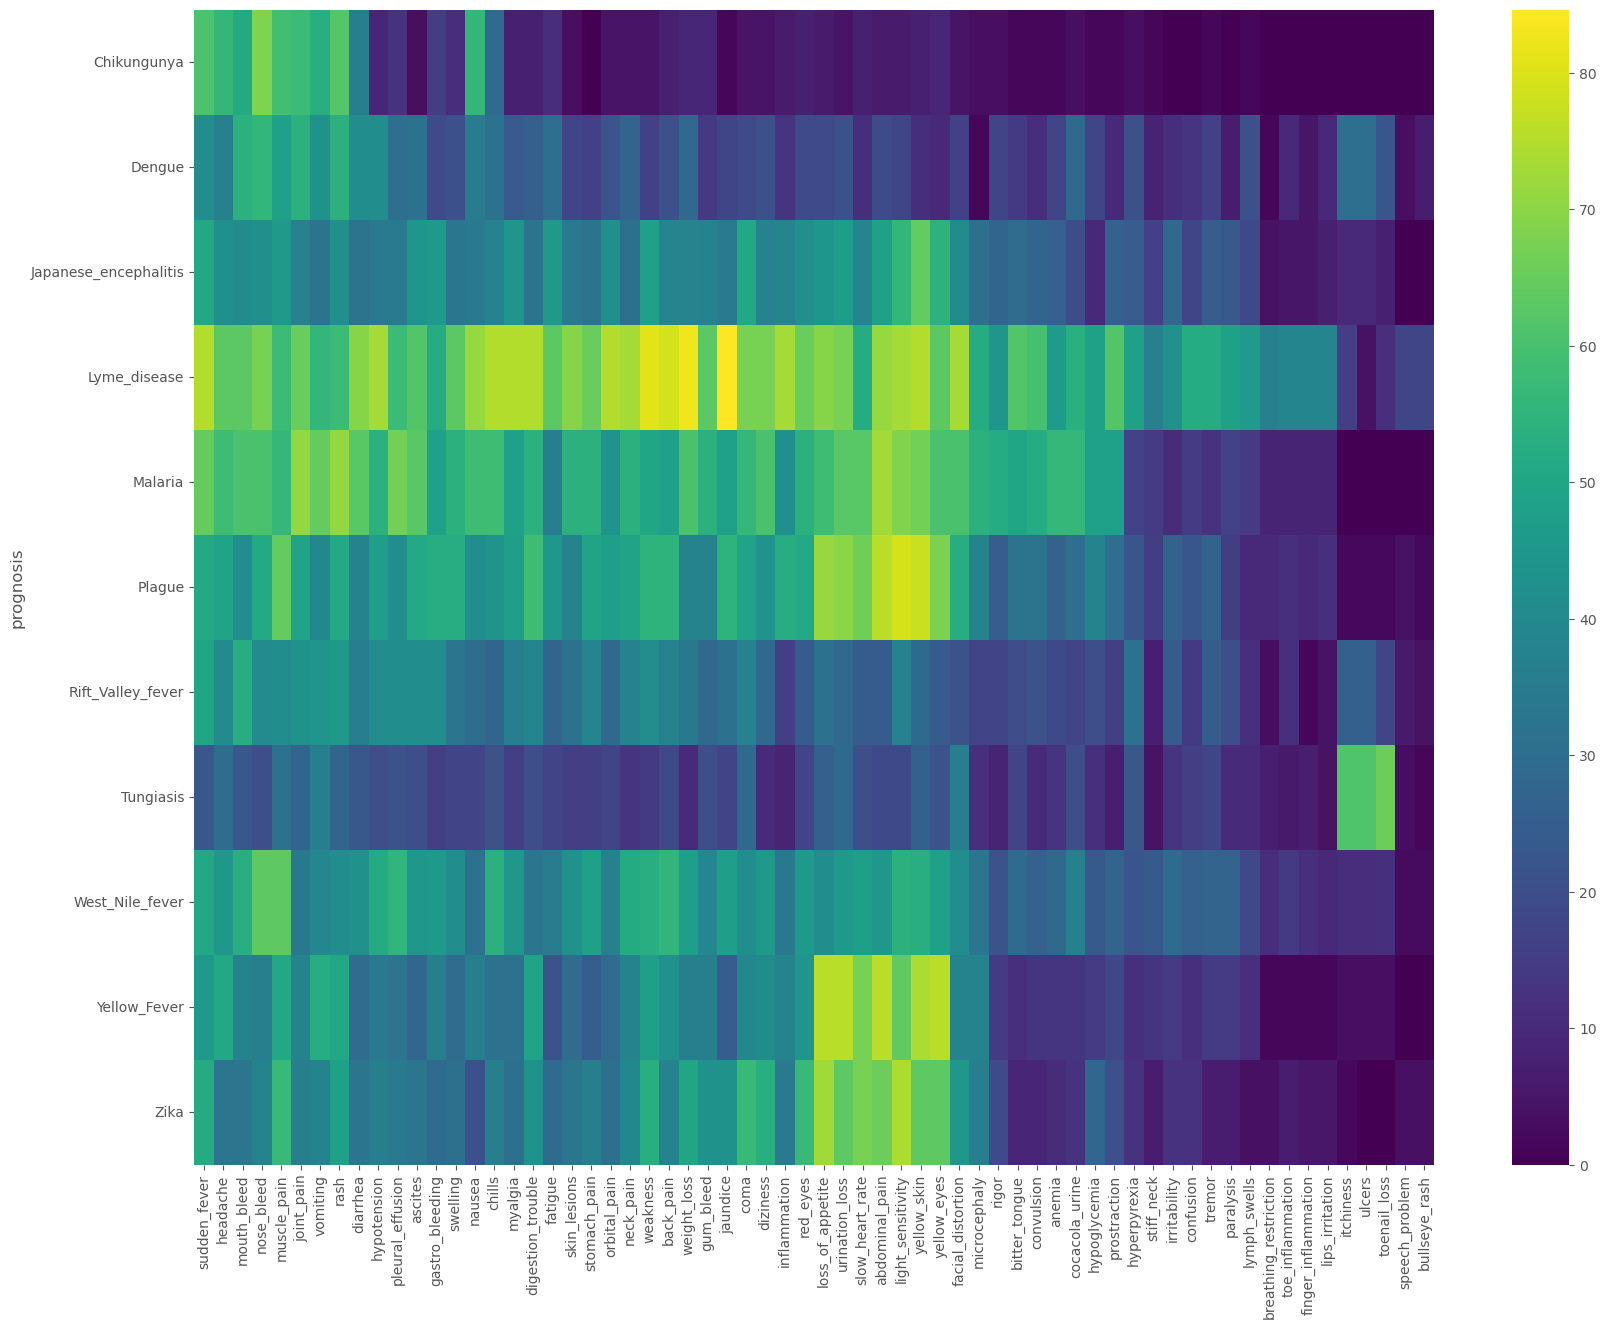

In [12]:
heatmap_disease = train.groupby('prognosis')[train.columns.tolist()[0:64]].sum()
heatmap_disease.loc['Chikungunya'] = round(100*heatmap_disease.loc['Chikungunya'].div(66), 2)
heatmap_disease.loc['Dengue'] = round(100*heatmap_disease.loc['Dengue'].div(63), 2)
heatmap_disease.loc['Japanese_encephalitis'] = round(100*heatmap_disease.loc['Japanese_encephalitis'].div(81), 2)
heatmap_disease.loc['Lyme_disease'] = round(100*heatmap_disease.loc['Lyme_disease'].div(52), 2)
heatmap_disease.loc['Malaria'] = round(100*heatmap_disease.loc['Malaria'].div(48), 2)
heatmap_disease.loc['Plague'] = round(100*heatmap_disease.loc['Plague'].div(53), 2)
heatmap_disease.loc['Rift_Valley_fever'] = round(100*heatmap_disease.loc['Rift_Valley_fever'].div(70), 2)
heatmap_disease.loc['Tungiasis'] = round(100*heatmap_disease.loc['Tungiasis'].div(70), 2)
heatmap_disease.loc['West_Nile_fever'] = round(100*heatmap_disease.loc['West_Nile_fever'].div(85), 2)
heatmap_disease.loc['Yellow_Fever'] = round(100*heatmap_disease.loc['Yellow_Fever'].div(61), 2)
heatmap_disease.loc['Zika'] = round(100*heatmap_disease.loc['Zika'].div(58), 2)

plt.figure(figsize = (20, 15))
sns.heatmap(heatmap_disease, cmap = 'viridis');
# plt.savefig('heatmap.png');

The color of each of the cells in the above heatmap represent the percentage of cases of a given disease that have the symptom. From the above heatmap, there are a couple of interesting patterns:

1. Plague, yellow fever, and zika have very similar percentage across the symptoms.
2. Dengue and tungiasis have very similar percentage across the symptoms. Maybe rift valley fever can be included in this group.
3. Chikungunya is different from the other diseases.
4. Lyme disease is very different from the other diseases.
5. Japanese encephalitis and West Nile fever have similar percentage across the symptoms.

The above could potentially be used to engineer a feature based on similarity on the symptoms.

<a id="6"></a>
# <h1 style="background-color:lightgray;font-family:newtimeroman;font-size:350%;text-align:center;border-radius: 15px 50px;">MAP@k Metric</h1>

Notice that the below code was obtained from this [notebook](https://www.kaggle.com/code/nandeshwar/mean-average-precision-map-k-metric-explained-code/notebook).


In [13]:
def apk(actual, predicted, k = 10):
    """
    Computes the average precision at k.
    This function computes the average prescision at k between two lists of
    items.
    Parameters
    ----------
    actual : list
             A list of elements that are to be predicted (order doesn't matter)
    predicted : list
                A list of predicted elements (order does matter)
    k : int, optional
        The maximum number of predicted elements
    Returns
    -------
    score : double
            The average precision at k over the input lists
    """
    if not actual:
        return 0.0

    if len(predicted)>k:
        predicted = predicted[:k]

    score = 0.0
    num_hits = 0.0

    for i,p in enumerate(predicted):
        # first condition checks whether it is valid prediction
        # second condition checks if prediction is not repeated
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i+1.0)

    return score / min(len(actual), k)

def mapk(actual, predicted, k = 10):
    """
    Computes the mean average precision at k.
    This function computes the mean average prescision at k between two lists
    of lists of items.
    Parameters
    ----------
    actual : list
             A list of lists of elements that are to be predicted 
             (order doesn't matter in the lists)
    predicted : list
                A list of lists of predicted elements
                (order matters in the lists)
    k : int, optional
        The maximum number of predicted elements
    Returns
    -------
    score : double
            The mean average precision at k over the input lists
    """
    return np.mean([apk(a,p,k) for a,p in zip(actual, predicted)])

<a id="7"></a>
# <h1 style="background-color:lightgray;font-family:newtimeroman;font-size:350%;text-align:center;border-radius: 15px 50px;">Baseline Modeling 1.0</h1> 

In this section, we train the popular XGBoost model on the raw data.

In [14]:
def selecting_top_3(arr): 
    n = arr.shape[0]
    out = np.zeros((n, 3))
    for i in range(0, n):
        out[i, ] = arr[i,].argsort()[::-1][:3]
    return out.astype('int32')

In [15]:
X = train.drop(columns = ['prognosis'], axis = 1)
le = LabelEncoder()
le.fit(train['prognosis'])
Y = pd.DataFrame(le.transform(train['prognosis']))

preds, cv_scores = list(), list()

skf = StratifiedKFold(n_splits = 5, random_state = 42, shuffle = True)
    
for train_ix, test_ix in skf.split(X, Y):
        
    X_train, X_test = X.iloc[train_ix], X.iloc[test_ix]
    Y_train, Y_test = Y.iloc[train_ix], Y.iloc[test_ix]
                
    XGB_md = XGBClassifier(objective = 'multi:softprob',
                           tree_method = 'gpu_hist',
                           colsample_bytree = 0.6,  
                           gamma = 0.8,  
                           learning_rate = 0.01, 
                           max_depth = 5,
                           min_child_weight = 5, 
                           n_estimators = 500, 
                           subsample = 0.7).fit(X_train, Y_train)

    XGB_pred_1 = selecting_top_3(XGB_md.predict_proba(X_test))
    cv_scores.append(mapk(Y_test.values.reshape(-1, 1), XGB_pred_1, k = 3))
    
    preds.append(XGB_md.predict_proba(test))
    
cv_score = np.mean(cv_scores)
print('The oof map3 score of the XGBoost model is', cv_score)

The oof map3 score of the XGBoost model is 0.3733359970698898


Next, we proceed to consolidate the predictions on the test dataset.

In [16]:
pred_agg = 0
for i in range(0, len(preds)):
    pred_agg += preds[i] / len(preds)
    
test_pred = selecting_top_3(pred_agg)
test_pred = test_pred.astype('int32')

test_shape = test_pred.shape
top_3_predictions = le.inverse_transform(test_pred.reshape(-1, 1))
top_3_predictions = top_3_predictions.reshape(test_shape)

submission['prognosis'] = [' '.join(each) for each in top_3_predictions]
submission.head(10)

/opt/conda/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,id,prognosis
0,707,Rift_Valley_fever Dengue Tungiasis
1,708,Dengue Chikungunya Rift_Valley_fever
2,709,West_Nile_fever Japanese_encephalitis Malaria
3,710,Japanese_encephalitis Rift_Valley_fever Yellow...
4,711,West_Nile_fever Japanese_encephalitis Plague
5,712,Zika Yellow_Fever Plague
6,713,Japanese_encephalitis Malaria Plague
7,714,Chikungunya Dengue Tungiasis
8,715,Yellow_Fever Zika Japanese_encephalitis
9,716,Plague Yellow_Fever Malaria


In [17]:
submission.to_csv('XGB_baseline.csv', index = False)

<a id="8"></a>
# <h1 style="background-color:lightgray;font-family:newtimeroman;font-size:350%;text-align:center;border-radius: 15px 50px;">Baseline Modeling 2.0</h1> 
 
 In this section, we train the old [LDA](https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.LinearDiscriminantAnalysis.html) model on the raw dataset.

In [18]:
preds, cv_scores = list(), list()

skf = StratifiedKFold(n_splits = 5, random_state = 42, shuffle = True)
    
for train_ix, test_ix in skf.split(X, Y):
        
    X_train, X_test = X.iloc[train_ix], X.iloc[test_ix]
    Y_train, Y_test = Y.iloc[train_ix], Y.iloc[test_ix]
                
    lda_md = LinearDiscriminantAnalysis().fit(X_train, Y_train)

    lda_pred_1 = selecting_top_3(lda_md.predict_proba(X_test))
    cv_scores.append(mapk(Y_test.values.reshape(-1, 1), lda_pred_1, k = 3))
    
    preds.append(lda_md.predict_proba(test))

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

In [19]:
cv_score = np.mean(cv_scores)
print('The oof map3 score of the LDA model is', cv_score)

The oof map3 score of the LDA model is 0.338664136116938


Next, we proceed to consolidate the predictions on the test dataset.

In [20]:
pred_agg = 0
for i in range(0, len(preds)):
    pred_agg += preds[i] / len(preds)
    
test_pred = selecting_top_3(pred_agg)
test_pred = test_pred.astype('int32')

test_shape = test_pred.shape
top_3_predictions = le.inverse_transform(test_pred.reshape(-1, 1))
top_3_predictions = top_3_predictions.reshape(test_shape)

submission['prognosis'] = [' '.join(each) for each in top_3_predictions]
submission.head(10)

/opt/conda/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,id,prognosis
0,707,Rift_Valley_fever Zika Dengue
1,708,Chikungunya Dengue Japanese_encephalitis
2,709,West_Nile_fever Japanese_encephalitis Yellow_F...
3,710,Japanese_encephalitis Rift_Valley_fever Yellow...
4,711,West_Nile_fever Plague Japanese_encephalitis
5,712,Zika Yellow_Fever West_Nile_fever
6,713,Japanese_encephalitis Malaria Plague
7,714,Dengue Chikungunya Rift_Valley_fever
8,715,Yellow_Fever Zika Plague
9,716,Plague Yellow_Fever West_Nile_fever


In [21]:
submission.to_csv('LDA_baseline.csv', index = False)

<a id="9"></a>
# <h1 style="background-color:lightgray;font-family:newtimeroman;font-size:350%;text-align:center;border-radius: 15px 50px;">Baseline Modeling 3.0</h1> 


In [22]:
preds, cv_scores = list(), list()

skf = StratifiedKFold(n_splits = 5, random_state = 42, shuffle = True)
    
for train_ix, test_ix in skf.split(X, Y):
        
    X_train, X_test = X.iloc[train_ix], X.iloc[test_ix]
    Y_train, Y_test = Y.iloc[train_ix], Y.iloc[test_ix]
                
    logit_md = LogisticRegression(solver = 'saga',
                                  penalty = 'l2',
                                  C = 0.071, 
                                  max_iter = 10000).fit(X_train, Y_train)

    logit_pred_1 = selecting_top_3(logit_md.predict_proba(X_test))
    cv_scores.append(mapk(Y_test.values.reshape(-1, 1), logit_pred_1, k = 3))
    
    preds.append(logit_md.predict_proba(test))

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

In [23]:
cv_score = np.mean(cv_scores)
print('The oof map3 score of the Logistic model is', cv_score)

The oof map3 score of the Logistic model is 0.3603419571804348


Next, we proceed to consolidate the predictions on the test dataset.

In [24]:
pred_agg = 0
for i in range(0, len(preds)):
    pred_agg += preds[i] / len(preds)
    
test_pred = selecting_top_3(pred_agg)
test_pred = test_pred.astype('int32')

test_shape = test_pred.shape
top_3_predictions = le.inverse_transform(test_pred.reshape(-1, 1))
top_3_predictions = top_3_predictions.reshape(test_shape)

submission['prognosis'] = [' '.join(each) for each in top_3_predictions]
submission.head(10)

/opt/conda/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,id,prognosis
0,707,Rift_Valley_fever Tungiasis Dengue
1,708,Chikungunya Dengue Rift_Valley_fever
2,709,West_Nile_fever Japanese_encephalitis Plague
3,710,Japanese_encephalitis Rift_Valley_fever Yellow...
4,711,West_Nile_fever Japanese_encephalitis Plague
5,712,Zika Yellow_Fever Plague
6,713,Malaria Japanese_encephalitis Plague
7,714,Dengue Chikungunya Tungiasis
8,715,Yellow_Fever Zika Japanese_encephalitis
9,716,Yellow_Fever Plague West_Nile_fever


In [25]:
submission.to_csv('Logistic_baseline.csv', index = False)

<a id="10"></a>
# <h1 style="background-color:lightgray;font-family:newtimeroman;font-size:350%;text-align:center;border-radius: 15px 50px;">Baseline Modeling 4.0</h1> 

In this section, we ensemble five starndard models.

In [26]:
def selecting_3(arr): 
    n = arr.shape[0]
    out = list()
    for i in range(0, n):
        out.append([elm[0] for elm in Counter(arr[i,]).most_common(3)])
    return np.array(out).reshape(n, 3)

In [27]:
ET_preds, ET_cv_scores = list(), list()
svm_preds, svm_cv_scores = list(), list()
lda_preds, lda_cv_scores = list(), list()
logit_preds, logit_cv_scores = list(), list()
ens_preds, ens_cv_scores = list(), list()

skf = StratifiedKFold(n_splits = 5, random_state = 42, shuffle = True)
    
for train_ix, test_ix in skf.split(X, Y):
        
    X_train, X_test = X.iloc[train_ix], X.iloc[test_ix]
    Y_train, Y_test = Y.iloc[train_ix], Y.iloc[test_ix]
        
    ################
    ## ExtraTrees ##
    ################
    
    ET_md = ExtraTreesClassifier(n_estimators = 500, 
                                 max_depth = 3,
                                 min_samples_split = 10, 
                                 min_samples_leaf = 10,
                                 max_features = 'sqrt',
                                 random_state = 15).fit(X_train, Y_train)

    ET_pred_1 = selecting_top_3(ET_md.predict_proba(X_test))
    ET_cv_scores.append(mapk(Y_test.values.reshape(-1, 1), ET_pred_1, k = 3))
    
    ET_pred_2 = selecting_top_3(ET_md.predict_proba(test))
    
    #########
    ## SVM ##
    #########
    
    svm_md = SVC(kernel = 'linear',
                 C = 0.1,
                 probability = True,
                 random_state = 10).fit(X_train, Y_train)
    
    svm_pred_1 = selecting_top_3(svm_md.predict_proba(X_test))
    svm_cv_scores.append(mapk(Y_test.values.reshape(-1, 1), svm_pred_1, k = 3))
    
    svm_pred_2 = selecting_top_3(svm_md.predict_proba(test))

    
    #########
    ## LDA ##
    #########
    
    lda_md = LinearDiscriminantAnalysis().fit(X_train, Y_train)

    lda_pred_1 = selecting_top_3(lda_md.predict_proba(X_test))
    lda_cv_scores.append(mapk(Y_test.values.reshape(-1, 1), lda_pred_1, k = 3))
    
    lda_pred_2 = selecting_top_3(lda_md.predict_proba(test))
    
    ##############
    ## Logistic ##
    ##############
    
    logit_md = LogisticRegression(solver = 'saga',
                                  penalty = 'l2',
                                  C = 0.071, 
                                  max_iter = 10000).fit(X_train, Y_train)

    logit_pred_1 = selecting_top_3(logit_md.predict_proba(X_test))
    logit_cv_scores.append(mapk(Y_test.values.reshape(-1, 1), logit_pred_1, k = 3))
    
    logit_pred_2 = selecting_top_3(logit_md.predict_proba(test))
    
    ##############
    ## Ensemble ##
    ##############
    
    ens_preds_oof = np.concatenate((ET_pred_1, svm_pred_1, lda_pred_1, logit_pred_1), axis = 1)
    ens_labels = le.inverse_transform(ens_preds_oof.reshape(-1, 1)).reshape(ens_preds_oof.shape)
    ens = selecting_3(ens_labels)
    ens_cv_scores.append(mapk(le.inverse_transform(Y_test).reshape(-1, 1), ens, k = 3))
    
    ens_preds_test = np.concatenate((ET_pred_2, svm_pred_2, lda_pred_2, logit_pred_2), axis = 1)
    ens_labels_test = le.inverse_transform(ens_preds_test.reshape(-1, 1)).reshape(ens_preds_test.shape)
    ens_preds.append(selecting_3(ens_labels_test))
    
ET_cv_score = np.mean(ET_cv_scores)
svm_cv_score = np.mean(svm_cv_scores)
lda_cv_score = np.mean(lda_cv_scores)
logit_cv_score = np.mean(logit_cv_scores)
ens_cv_score = np.mean(ens_cv_scores)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:23: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=Tru

Next, we proceed to compare model performance.

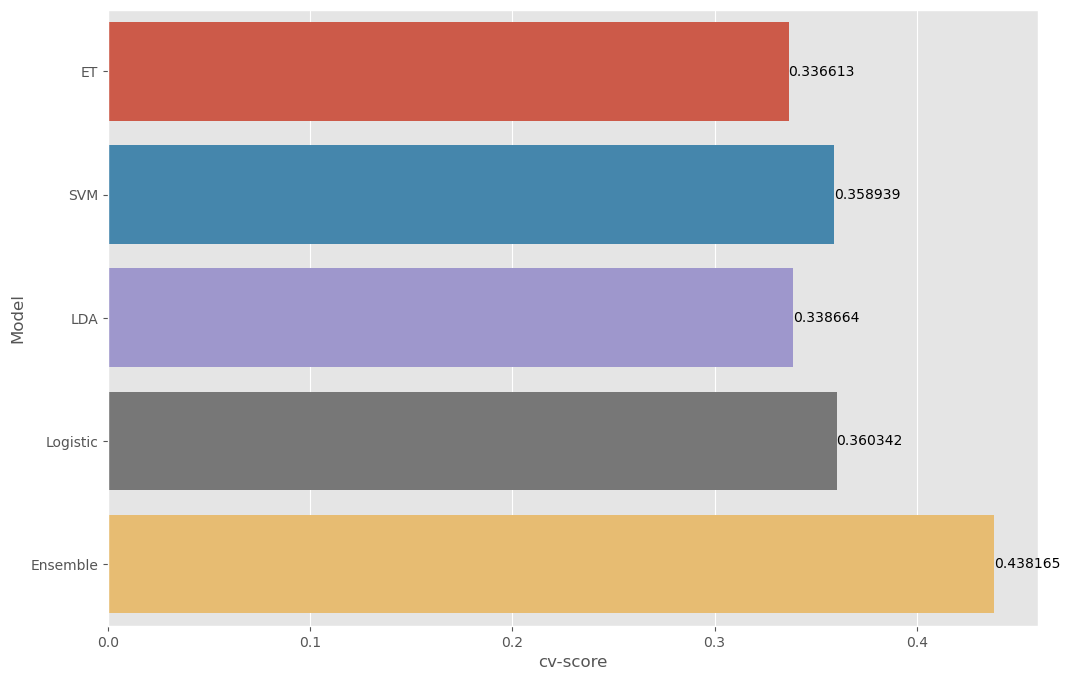

In [28]:
model_perf = pd.DataFrame({'Model': ['ET' ,'SVM', 'LDA', 'Logistic', 'Ensemble'],
                           'cv-score': [ET_cv_score, svm_cv_score, lda_cv_score, logit_cv_score, ens_cv_score]})

plt.figure(figsize = (12, 8))
ax = sns.barplot(y = 'Model', x = 'cv-score', data = model_perf)
ax.bar_label(ax.containers[0]);

Finally, we consolidate predictions on the test dataset.

In [29]:
out = np.concatenate((ens_preds[0], ens_preds[1], ens_preds[2], ens_preds[3], ens_preds[4]), axis = 1) 
out = selecting_3(out)

submission['prognosis'] = [' '.join(each) for each in out]
submission.head(10)

,id,prognosis
0,707,Rift_Valley_fever Tungiasis Japanese_encephalitis
1,708,Chikungunya Dengue Rift_Valley_fever
2,709,West_Nile_fever Japanese_encephalitis Plague
3,710,Japanese_encephalitis Rift_Valley_fever Yellow...
4,711,West_Nile_fever Japanese_encephalitis Plague
5,712,Yellow_Fever Zika West_Nile_fever
6,713,Japanese_encephalitis Malaria West_Nile_fever
7,714,Chikungunya Dengue Rift_Valley_fever
8,715,Yellow_Fever Japanese_encephalitis Zika
9,716,Plague Yellow_Fever West_Nile_fever


In [30]:
submission.to_csv('ensemble_baseline.csv', index = False)

<a id="11"></a>
# <h1 style="background-color:lightgray;font-family:newtimeroman;font-size:350%;text-align:center;border-radius: 15px 50px;">Baseline Modeling 5.0</h1> 

In this section, we re-train the models from baseline modeling 4.0 but now we include the original dataset. We first read and concatenate the original and generated datasets.

In [31]:
train = pd.read_csv('../input/playground-series-s3e13/train.csv')
test = pd.read_csv('../input/playground-series-s3e13/test.csv')
submission = pd.read_csv('../input/playground-series-s3e13/sample_submission.csv')

train.drop(columns = 'id', axis = 1, inplace = True)
test.drop(columns = 'id', axis = 1, inplace = True)

train['is_generated'] = 1
test['is_generated'] = 1

org_train = pd.read_csv('../input/vector-borne-disease-prediction/trainn.csv')
org_train['prognosis'] = org_train['prognosis'].apply(lambda x: x.replace(" ", "_"))

org_test = pd.read_csv('../input/vector-borne-disease-prediction/testt.csv')
org_test['prognosis'] = org_test['prognosis'].apply(lambda x: x.replace(" ", "_"))

org = pd.concat([org_train, org_test], axis = 0).reset_index(drop = True)
org[org.columns.tolist()[0:64]] = org[org.columns.tolist()[0:64]].astype('int32')
org['is_generated'] = 0

train = pd.concat([train, org], axis = 0).reset_index(drop = True)

X = train.drop(columns = ['prognosis'], axis = 1)
le = LabelEncoder()
le.fit(train['prognosis'])
Y = pd.DataFrame(le.transform(train['prognosis']))

Next, we re-run the cross-validation routine.

In [32]:
ET_preds, ET_cv_scores = list(), list()
svm_preds, svm_cv_scores = list(), list()
lda_preds, lda_cv_scores = list(), list()
logit_preds, logit_cv_scores = list(), list()
ens_preds, ens_cv_scores = list(), list()

skf = StratifiedKFold(n_splits = 5, random_state = 42, shuffle = True)
    
for train_ix, test_ix in skf.split(X, Y):
        
    X_train, X_test = X.iloc[train_ix], X.iloc[test_ix]
    Y_train, Y_test = Y.iloc[train_ix], Y.iloc[test_ix]
        
    ################
    ## ExtraTrees ##
    ################
    
    ET_md = ExtraTreesClassifier(n_estimators = 500, 
                                 max_depth = 3,
                                 min_samples_split = 10, 
                                 min_samples_leaf = 10,
                                 max_features = 'sqrt',
                                 random_state = 15).fit(X_train, Y_train)

    ET_pred_1 = selecting_top_3(ET_md.predict_proba(X_test))
    ET_cv_scores.append(mapk(Y_test.values.reshape(-1, 1), ET_pred_1, k = 3))
    
    ET_pred_2 = selecting_top_3(ET_md.predict_proba(test))
    
    #########
    ## SVM ##
    #########
    
    svm_md = SVC(kernel = 'linear',
                 C = 0.1,
                 probability = True,
                 random_state = 10).fit(X_train, Y_train)
    
    svm_pred_1 = selecting_top_3(svm_md.predict_proba(X_test))
    svm_cv_scores.append(mapk(Y_test.values.reshape(-1, 1), svm_pred_1, k = 3))
    
    svm_pred_2 = selecting_top_3(svm_md.predict_proba(test))

    
    #########
    ## LDA ##
    #########
    
    lda_md = LinearDiscriminantAnalysis().fit(X_train, Y_train)

    lda_pred_1 = selecting_top_3(lda_md.predict_proba(X_test))
    lda_cv_scores.append(mapk(Y_test.values.reshape(-1, 1), lda_pred_1, k = 3))
    
    lda_pred_2 = selecting_top_3(lda_md.predict_proba(test))
    
    ##############
    ## Logistic ##
    ##############
    
    logit_md = LogisticRegression(solver = 'saga',
                                  penalty = 'l2',
                                  C = 0.071, 
                                  max_iter = 10000).fit(X_train, Y_train)

    logit_pred_1 = selecting_top_3(logit_md.predict_proba(X_test))
    logit_cv_scores.append(mapk(Y_test.values.reshape(-1, 1), logit_pred_1, k = 3))
    
    logit_pred_2 = selecting_top_3(logit_md.predict_proba(test))
    
    ##############
    ## Ensemble ##
    ##############
    
    ens_preds_oof = np.concatenate((ET_pred_1, svm_pred_1, lda_pred_1, logit_pred_1), axis = 1)
    ens_labels = le.inverse_transform(ens_preds_oof.reshape(-1, 1)).reshape(ens_preds_oof.shape)
    ens = selecting_3(ens_labels)
    ens_cv_scores.append(mapk(le.inverse_transform(Y_test).reshape(-1, 1), ens, k = 3))
    
    ens_preds_test = np.concatenate((ET_pred_2, svm_pred_2, lda_pred_2, logit_pred_2), axis = 1)
    ens_labels_test = le.inverse_transform(ens_preds_test.reshape(-1, 1)).reshape(ens_preds_test.shape)
    ens_preds.append(selecting_3(ens_labels_test))
    
ET_cv_score = np.mean(ET_cv_scores)
svm_cv_score = np.mean(svm_cv_scores)
lda_cv_score = np.mean(lda_cv_scores)
logit_cv_score = np.mean(logit_cv_scores)
ens_cv_score = np.mean(ens_cv_scores)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:23: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=Tru

Next, we visualize model performance.

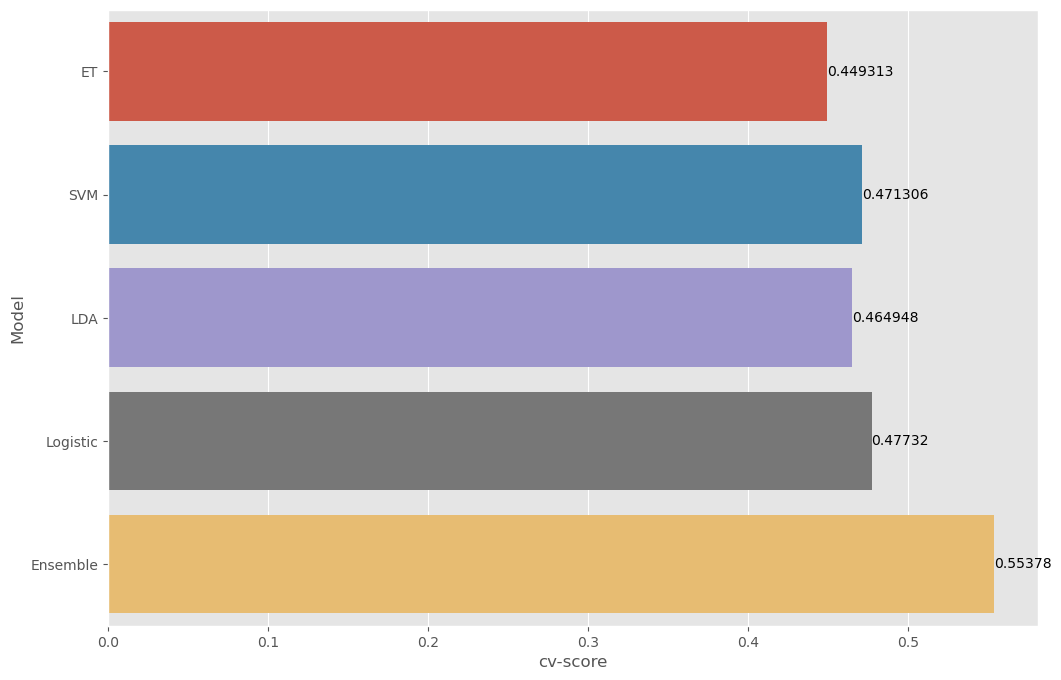

In [33]:
model_perf = pd.DataFrame({'Model': ['ET' ,'SVM', 'LDA', 'Logistic', 'Ensemble'],
                           'cv-score': [ET_cv_score, svm_cv_score, lda_cv_score, logit_cv_score, ens_cv_score]})

plt.figure(figsize = (12, 8))
ax = sns.barplot(y = 'Model', x = 'cv-score', data = model_perf)
ax.bar_label(ax.containers[0]);

Finally, we aggregate the predictions from the cross-validation routine.

In [34]:
out = np.concatenate((ens_preds[0], ens_preds[1], ens_preds[2], ens_preds[3], ens_preds[4]), axis = 1) 
out = selecting_3(out)

submission['prognosis'] = [' '.join(each) for each in out]
submission.head(10)

,id,prognosis
0,707,Tungiasis Dengue Japanese_encephalitis
1,708,Chikungunya Dengue Rift_Valley_fever
2,709,Japanese_encephalitis West_Nile_fever Zika
3,710,Japanese_encephalitis Rift_Valley_fever Tungiasis
4,711,West_Nile_fever Japanese_encephalitis Zika
5,712,Yellow_Fever Zika Malaria
6,713,Malaria Japanese_encephalitis Plague
7,714,Chikungunya Dengue Rift_Valley_fever
8,715,Yellow_Fever Zika Japanese_encephalitis
9,716,Yellow_Fever Zika West_Nile_fever


In [35]:
submission.to_csv('ensemble_baseline_org.csv', index = False)

<a id="12"></a>
# <h1 style="background-color:lightgray;font-family:newtimeroman;font-size:350%;text-align:center;border-radius: 15px 50px;">Baseline Modeling 6.0</h1> 

In this section, we improve the performance of baseline modeling 5.0 but with a simpler structure. That is, we employ [LDA](https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.LinearDiscriminantAnalysis.html#sklearn.discriminant_analysis.LinearDiscriminantAnalysis) as feature extractors. 

In [36]:
svm_preds, svm_cv_scores = list(), list()

skf = StratifiedKFold(n_splits = 5, random_state = 42, shuffle = True)
    
for train_ix, test_ix in skf.split(X, Y):
        
    X_train, X_test = X.iloc[train_ix], X.iloc[test_ix]
    Y_train, Y_test = Y.iloc[train_ix], Y.iloc[test_ix]
    
    ##############################
    ## SVM (with LDA as inputs) ##
    ##############################
    
    lda = LinearDiscriminantAnalysis(n_components = 8)
    svm_md = make_pipeline(lda, SVC(kernel = 'rbf',
                                    C = 1,
                                    probability = True,
                                    random_state = 10)).fit(X_train, Y_train)
    svm_pred_1 = selecting_top_3(svm_md.predict_proba(X_test))
    svm_cv_scores.append(mapk(Y_test.values.reshape(-1, 1), svm_pred_1, k = 3))
    
    svm_preds.append(selecting_top_3(svm_md.predict_proba(test)))

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

In [37]:
svm_cv_score = np.mean(svm_cv_scores)
print('The oof map@3 cv-score is', svm_cv_score)

The oof map@3 cv-score is 0.46546391752577315


Finally, we aggregate the predictions from the cross-validation routine.

In [38]:
out = np.concatenate((svm_preds[0], svm_preds[1], svm_preds[2], svm_preds[3], svm_preds[4]), axis = 1) 
out = selecting_3(out)
out = le.inverse_transform(out.reshape(-1, 1)).reshape(out.shape)

submission['prognosis'] = [' '.join(each) for each in out]
submission.head(10)

/opt/conda/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,id,prognosis
0,707,Dengue Rift_Valley_fever Tungiasis
1,708,Dengue Chikungunya West_Nile_fever
2,709,West_Nile_fever Japanese_encephalitis Yellow_F...
3,710,Rift_Valley_fever Japanese_encephalitis Zika
4,711,West_Nile_fever Zika Yellow_Fever
5,712,Zika Yellow_Fever Malaria
6,713,Malaria Japanese_encephalitis West_Nile_fever
7,714,Dengue Rift_Valley_fever West_Nile_fever
8,715,Yellow_Fever Zika Plague
9,716,Zika Plague Yellow_Fever


In [39]:
submission.to_csv('lda_svm.csv', index = False)

<a id="13"></a>
# <h1 style="background-color:lightgray;font-family:newtimeroman;font-size:350%;text-align:center;border-radius: 15px 50px;">Model Comparison</h1> 

| Model | local cv | LB |
| --- | --- | ---- |
| XGBoost | 0.37333 | 0.33995 |
| LDA | 0.33866 | 0.37527 |
| Logistic | 0.36034 | 0.36975 |
| Baseline 4.0 | 0.43816 | 0.37969 |
| Baseline 5.0 | 0.55378 | 0.39293 |
| Baseline 6.0 | 0.46546 | 0.41501 |